<a href="https://colab.research.google.com/github/shuodeng521-sys/ST-554-Project1-Shuo-Anna-Jillian/blob/main/Task1/Project1_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title: Project 1 Task 1   
Class: ST-554 Big Data  
Date: 2/20/2026  
Author: Anna Giczewska

## Task 1

This task involves writing two gradient descent type algorithms to find the optimal constant to use for
squared error loss (ends up being the sample mean) and to find the optimal intercept and slope from a
simple linear regression model.


## Introduction

Monitoring carcinogenic air pollutants is important for protecting public health, but high-quality sensing equipment is often expensive and difficult to deploy widely. Prior work by De Vito et al. (2008) suggests that low-cost gas sensors may be calibrated using statistical models to approximate true pollutant concentrations.

In this task, I focus on modeling the true benzene concentration C6H6 (GT) using simple and multiple linear regression. The goal is to evaluate how well sensor and weather variables can predict benzene levels, and to compare model performance using a rolling one-step-ahead cross-validation approach.

In [1]:
#Read data

!pip install ucimlrepo # Install UCI package - only needs to be done 1st time

In [2]:
# Import modules
import pandas as pd
import ucimlrepo as uci
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Fetch the Air Quality Multisensor dataset
air_quality = uci.fetch_ucirepo(id=360)

In [4]:
# Print var info
air_quality.variables

,name,role,type,demographic,description,units,missing_values
0,Date,Feature,Date,None,None,None,no
1,Time,Feature,Categorical,None,None,None,no
2,CO(GT),Feature,Integer,None,True hourly averaged concentration CO in mg/m^...,mg/m^3,no
3,PT08.S1(CO),Feature,Categorical,None,hourly averaged sensor response (nominally CO...,None,no
4,NMHC(GT),Feature,Integer,None,True hourly averaged overall Non Metanic Hydro...,microg/m^3,no
5,C6H6(GT),Feature,Continuous,None,True hourly averaged Benzene concentration in...,microg/m^3,no
6,PT08.S2(NMHC),Feature,Categorical,None,hourly averaged sensor response (nominally NMH...,None,no
7,NOx(GT),Feature,Integer,None,True hourly averaged NOx concentration in ppb...,ppb,no
8,PT08.S3(NOx),Feature,Categorical,None,hourly averaged sensor response (nominally NOx...,None,no
9,NO2(GT),Feature,Integer,None,True hourly averaged NO2 concentration in micr...,microg/m^3,no


In [5]:
#Remove any observations where the C6H6(GT) or CO(GT) are -200 as these represent missing values (which we’ll ignore).

# Get the features dataframe
df = air_quality.data.features.copy()

# How many -200s you have before filtering
missing_counts = (df[['C6H6(GT)', 'CO(GT)']] == -200).sum()
print("Counts of -200 before filtering:\n", missing_counts)

# Remove rows where either column is -200
df_clean = df[(df['C6H6(GT)'] != -200) & (df['CO(GT)'] != -200)].copy()

print("\nRows before:", len(df))
print("Rows after: ", len(df_clean))
print("Removed:    ", len(df) - len(df_clean))

df_clean.head()


Counts of -200 before filtering:
 C6H6(GT)     366
CO(GT)      1683
dtype: int64

Rows before: 9357
Rows after:  7344
Removed:     2013


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [6]:
#Assign clean version of the data frame back to df
df=df_clean

## Data quality checks and exploratory plots (variables used)

Before fitting models, I run a few quick checks on the variables used in this task: **C6H6(GT)** and **PT08.S1(CO)**.

The goal is to inspect the distributions of the variables, and visualize the relationship between the sensor reading and benzene concentration.

Any remaining -200 values?
C6H6(GT)       0
PT08.S1(CO)    0
dtype: int64

Missing values (NaN):
C6H6(GT)       0
PT08.S1(CO)    0
dtype: int64

Summary statistics:
          C6H6(GT)  PT08.S1(CO)
count  7344.000000  7344.000000
mean     10.275735  1110.580746
std       7.441068   218.681331
min       0.200000   647.000000
25%       4.600000   946.000000
50%       8.500000  1075.000000
75%      14.300000  1246.000000
max      63.700000  2040.000000


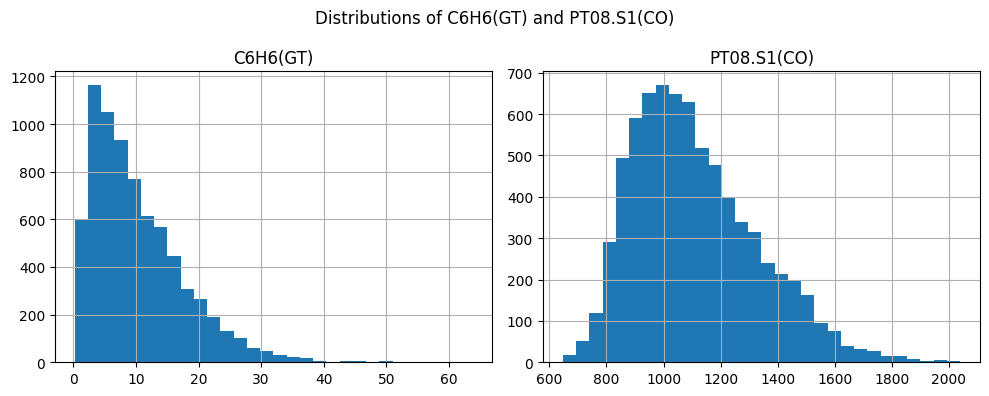

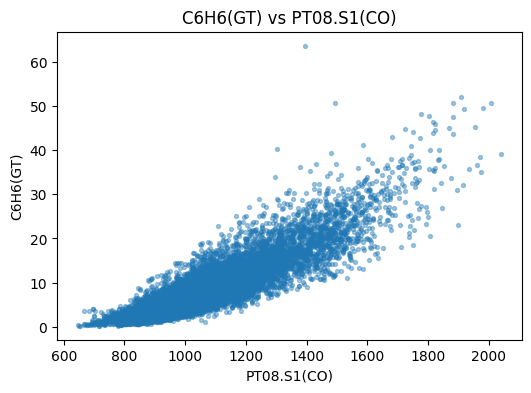


Correlation between PT08.S1(CO) and C6H6(GT): 0.8793788803003251


In [7]:
# Variables used in Task 1
cols = ["C6H6(GT)", "PT08.S1(CO)"]

# 1) Basic data quality checks
print("Any remaining -200 values?")
print((df[cols] == -200).sum())

print("\nMissing values (NaN):")
print(df[cols].isna().sum())

print("\nSummary statistics:")
print(df[cols].describe())

# 2) Histograms
df[cols].hist(bins=30, figsize=(10, 4))
plt.suptitle("Distributions of C6H6(GT) and PT08.S1(CO)")
plt.tight_layout()
plt.show()

# 3) Scatter plot: predictor vs response
plt.figure(figsize=(6, 4))
plt.scatter(df["PT08.S1(CO)"], df["C6H6(GT)"], s=8, alpha=0.4)
plt.xlabel("PT08.S1(CO)")
plt.ylabel("C6H6(GT)")
plt.title("C6H6(GT) vs PT08.S1(CO)")
plt.show()

# 4) Optional: correlation (simple numeric check of linear association)
corr_val = df["PT08.S1(CO)"].corr(df["C6H6(GT)"])
print("\nCorrelation between PT08.S1(CO) and C6H6(GT):", corr_val)

## Prediction of C6H6(GT)

In [8]:
# Helper: RMSE for a constant c
def rmse_constant(y, c):
    return np.sqrt(np.mean((y - c)**2))

### Grid search for best constant c using only y

In this step, I estimate the best constant predictor \(c\) for a response variable \(y\) by using a grid search.

The idea is to predict every observation with the same value \(c\), compute the RMSE for each candidate value, and then choose the value that gives the smallest RMSE.

To make the search efficient and focused on realistic values, I build the grid between the **first quartile (Q1)** and **third quartile (Q3)** of \(y\). I then apply this function to **C6H6(GT)**.

In [9]:
def grid_search_best_c(y, grid_size=1000):
    q1, q3 = np.quantile(y, [0.25, 0.75])
    c_grid = np.linspace(q1, q3, grid_size)

    rmse_vals = [rmse_constant(y, c) for c in c_grid]
    best_idx = int(np.argmin(rmse_vals))
    return c_grid[best_idx], rmse_vals[best_idx], (q1, q3)

# Run for C6H6(GT)
y_c6h6 = df["C6H6(GT)"].to_numpy()
best_c, best_rmse, (q1, q3) = grid_search_best_c(y_c6h6)
print("C6H6(GT): best c =", best_c, "best RMSE =", best_rmse, "grid from", (q1, q3))

C6H6(GT): best c = 10.280180180180182 best RMSE = 7.440562418757215 grid from (np.float64(4.6), np.float64(14.3))


The grid search returns the constant \(c\) that minimizes RMSE for **C6H6(GT)** over the specified grid.

This value should be close to the **sample mean** of the response, since under squared error loss the mean is the optimal constant predictor. The resulting RMSE also provides a useful **baseline** that later regression models should improve upon.

### Check: run the same function but with PT08.S1(CO) as y

As a quick check, I apply the same grid-search procedure to **PT08.S1(CO)** instead of **C6H6(GT)**.

This helps confirm that the method is working as expected for a different variable. Under squared error / RMSE, the best constant predictor should again be close to the **sample mean** of the chosen response variable.

In [10]:
y_pt = df["PT08.S1(CO)"].to_numpy()
best_c2, best_rmse2, (q1_2, q3_2) = grid_search_best_c(y_pt)
print("PT08.S1(CO): best c =", best_c2, "best RMSE =", best_rmse2, "grid from", (q1_2, q3_2))

PT08.S1(CO): best c = 1110.5645645645645 best RMSE = 218.6664431268348 grid from (np.float64(946.0), np.float64(1246.0))


The result shows the RMSE-minimizing constant for **PT08.S1(CO)** over the selected grid.

As expected, the optimal constant is close to the center of the variable's distribution (approximately its mean), which is consistent with the same squared-error principle observed for **C6H6(GT)**. This serves as a useful sanity check for the grid-search function.

### Grid search for best b0, b1 (predict C6H6 from PT08.S1(CO))

I now move from a constant-only model to a simple linear regression model, where **C6H6(GT)** is predicted from **PT08.S1(CO)** using

$\hat{y} = b_0 + b_1 x$

To estimate the best parameters, I use a grid search over candidate values of the intercept \(b_0\) and slope \(b_1\), and select the pair that minimizes RMSE.

To make the computation faster, I use a vectorized formula for MSE based on precomputed sample moments (such as \(E[y]\), \(E[x]\), and \(E[xy]\)) rather than looping through all observations for every parameter pair.

In [11]:
def grid_search_best_b0_b1(x, y):
    # Create candidate values for the intercept (b0) and slope (b1)
    # We will search over all combinations of these values.
    b0_grid = np.arange(-25, -15 + 0.0001, 0.1)   # intercept candidates: -25 to -15
    b1_grid = np.arange(-5, 5 + 0.0001, 0.01)     # slope candidates: -5 to 5

    # Precompute sample moments used in the expanded MSE formula.
    # This makes the grid search much faster than computing predictions
    # and residuals for every (b0, b1) pair in nested loops.
    Ey2  = np.mean(y**2)
    Ey   = np.mean(y)
    Exy  = np.mean(x*y)
    Ex   = np.mean(x)
    Ex2  = np.mean(x**2)

    # Reshape grids so broadcasting creates a full 2D parameter surface:
    # - B0 varies down rows
    # - B1 varies across columns
    B0 = b0_grid[:, None]        # shape: (number of b0 values, 1)
    B1 = b1_grid[None, :]        # shape: (1, number of b1 values)

    # Compute MSE for every (b0, b1) pair using the expanded formula:
    # MSE = E[(y - (b0 + b1x))^2]
    #
    # Expanded form:
    # E[y^2] - 2b0E[y] - 2b1E[xy] + b0^2 + 2b0b1E[x] + b1^2E[x^2]
    #
    # Using this formula avoids looping over all observations repeatedly.
    mse = (Ey2
           - 2*B0*Ey
           - 2*B1*Exy
           + (B0**2)
           + 2*B0*B1*Ex
           + (B1**2)*Ex2)

    # Convert MSE surface to RMSE surface (same minimizer, easier to interpret)
    rmse = np.sqrt(mse)

    # Find the row/column location of the smallest RMSE in the 2D grid
    idx = np.unravel_index(np.argmin(rmse), rmse.shape)

    # Recover the corresponding parameter values
    best_b0 = b0_grid[idx[0]]
    best_b1 = b1_grid[idx[1]]
    best_rmse = rmse[idx]

    # Return the best intercept, best slope, and the minimum RMSE
    return best_b0, best_b1, best_rmse

# Set predictor x and response y for the simple linear regression model
# x = PT08.S1(CO) sensor reading
# y = C6H6(GT) true benzene concentration
x = df["PT08.S1(CO)"].to_numpy()
y = df["C6H6(GT)"].to_numpy()

# Run grid search to find the RMSE-minimizing intercept and slope
best_b0, best_b1, best_rmse = grid_search_best_b0_b1(x, y)

# Print the best-fitting parameters and model RMSE
print("Best b0:", best_b0, "Best b1:", best_b1, "Best RMSE:", best_rmse)

Best b0: -22.99999999999997 Best b1: 0.02999999999989278 Best RMSE: 3.54290539083074


The grid search returns the intercept and slope that produce the lowest RMSE for predicting **C6H6(GT)** from **PT08.S1(CO)**.

Comparing this RMSE to the constant-model RMSE provides a direct measure of how much predictive value is gained by including the sensor reading in a linear model. A lower RMSE here indicates that **PT08.S1(CO)** contains useful information about benzene concentration.

### Predict C6H6(GT) for x = [946, 1075, 1246]

Using the fitted linear model from the grid search, I now generate predictions of **C6H6(GT)** for three example values of **PT08.S1(CO)**.

These values (946, 1075, and 1246) were chosen because they align with key summary statistics for **PT08.S1(CO)**: 946 is the first quartile (Q1), 1075 is the median, and 1246 is the third quartile (Q3). Since the earlier grid search used the Q1-Q3 range, these values provide convenient examples for illustrating how the fitted line converts sensor readings into predicted benzene concentration.

In [12]:
for new_x in [946, 1075, 1246]:
    pred = best_b0 + best_b1 * new_x
    print("x =", new_x, "=> predicted C6H6(GT) =", pred)

x = 946 => predicted C6H6(GT) = 5.3799999998985975
x = 1075 => predicted C6H6(GT) = 9.249999999884764
x = 1246 => predicted C6H6(GT) = 14.379999999866428


### Gradient descent for best constant c

In [13]:
def diff_quotient_c(y, c, delta):
    return (rmse_constant(y, c + delta) - rmse_constant(y, c)) / delta

def gradient_descent_c(y, start_c, step_size, delta=0.001, tol=0.0001, max_iter=20000):
    cur = start_c # current estimate of the constant c

    for i in range(max_iter):
        # Approximate the slope (derivative) of RMSE at the current c
        slope = diff_quotient_c(y, cur, delta)

        # Gradient descent update:
        # move in the opposite direction of the slope to reduce RMSE
        new = cur - slope * step_size

        # Stop if the parameter update is very small (convergence criterion)
        if abs(new - cur) < tol:
            return new, rmse_constant(y, new), i+1

        # Otherwise continue from the updated value
        cur = new

    # Return the last value if max_iter is reached before convergence
    return cur, rmse_constant(y, cur), max_iter  # if it hits max_iter

# C6H6(GT) use start 0
gd_c, gd_rmse, iters = gradient_descent_c(y_c6h6, start_c=0, step_size=0.01, delta=0.001, tol=0.0001, max_iter=20000)
print("GD C6H6: c =", gd_c, "RMSE =", gd_rmse, "iters =", iters)

# PT08.S1(CO) use start 1100
gd_c2, gd_rmse2, iters2 = gradient_descent_c(y_pt, start_c=1100, step_size=0.1, delta=0.001, tol=0.0001, max_iter=30000)
print("GD PT08.S1(CO): c =", gd_c2, "RMSE =", gd_rmse2, "iters =", iters2)

GD C6H6: c = 10.200993520073336 RMSE = 7.440936478911602 iters = 3966
GD PT08.S1(CO): c = 1110.3616956683077 RMSE = 218.66655224571102 iters = 8483


These predictions show how the fitted regression line maps **PT08.S1(CO)** readings to estimated **C6H6(GT)** values.

Because the estimated slope is positive, the predicted benzene concentration increases as the sensor reading increases. This is consistent with the earlier grid-search result and suggests a positive relationship between the sensor response and true benzene concentration.

### Gradient descent for best b0, b1

In this section, I use a gradient descent style algorithm to estimate the intercept $b_0$ and slope $b_1$ for the simple linear regression model predicting **C6H6(GT)** from **PT08.S1(CO)**.

I first define a function for RMSE, then approximate the partial derivatives with respect to $b_0$ and $b_1$ using finite-difference quotients. At each iteration, both parameters are updated in the direction that reduces RMSE, and the algorithm stops when the parameter changes become very small (or when the maximum number of iterations is reached).

This provides an iterative alternative to the earlier grid search and allows me to compare the two optimization approaches.

In [14]:
def rmse_b0_b1(x, y, b0, b1):
    return np.sqrt(np.mean((y - (b0 + b1*x))**2))

def diff_quotient_b0(x, y, b0, b1, delta0):
    return (rmse_b0_b1(x, y, b0 + delta0, b1) - rmse_b0_b1(x, y, b0, b1)) / delta0

def diff_quotient_b1(x, y, b0, b1, delta1):
    return (rmse_b0_b1(x, y, b0, b1 + delta1) - rmse_b0_b1(x, y, b0, b1)) / delta1

def gradient_descent_b0_b1(x, y,
                           start_b0=-20, start_b1=0,
                           step_b0=0.5, step_b1=0.00005,
                           delta=0.005, tol=0.0001,
                           max_iter=100000):
    cur_b0, cur_b1 = start_b0, start_b1 # initialize parameters

    for i in range(max_iter):
        # Approximate partial derivative with respect to b0
        slope_b0 = diff_quotient_b0(x, y, cur_b0, cur_b1, delta)

        # Update b0 in the negative gradient direction
        new_b0 = cur_b0 - slope_b0 * step_b0

        # Approximate partial derivative with respect to b1
        # (using the updated b0 and current b1)
        slope_b1 = diff_quotient_b1(x, y, new_b0, cur_b1, delta)

        # Update b1 in the negative gradient direction
        new_b1 = cur_b1 - slope_b1 * step_b1

        # Measure total movement in parameter space
        move = np.linalg.norm([new_b0 - cur_b0, new_b1 - cur_b1])

        # Update current parameters
        cur_b0, cur_b1 = new_b0, new_b1

        # Stop when the parameter updates are sufficiently small
        if move < tol:
            break

    return cur_b0, cur_b1, rmse_b0_b1(x, y, cur_b0, cur_b1), i+1

gd_b0, gd_b1, gd_rmse_line, gd_iters = gradient_descent_b0_b1(x, y)
print("GD best b0:", gd_b0, "GD best b1:", gd_b1, "RMSE:", gd_rmse_line, "iters:", gd_iters)

for new_x in [946, 1075, 1246]:
    pred = gd_b0 + gd_b1 * new_x
    print("x =", new_x, "=> predicted C6H6(GT) =", pred)

GD best b0: -22.304829758047333 GD best b1: -0.0014903666813404631 RMSE: 35.097272964378526 iters: 100000
x = 946 => predicted C6H6(GT) = -23.714716638595412
x = 1075 => predicted C6H6(GT) = -23.90697394048833
x = 1246 => predicted C6H6(GT) = -24.16182664299755


The output reports the gradient descent estimates of $b_0$ and $b_1$, the resulting RMSE, and the number of iterations used. I also use the fitted gradient descent line to generate predictions for the same example sensor values (946, 1075, and 1246) so they can be compared directly with the grid-search model predictions.

Ideally, the gradient descent estimates should be close to the grid-search solution if the algorithm converges well. If the RMSE is much larger or the fitted slope differs substantially, that suggests the tuning choices may need adjustment.

### Final Summary

- The best constant predictor for **C6H6(GT)** was approximately **10.28** (RMSE **~7.44**), which is close to the sample mean.
- Gradient descent for the constant model produced a similar result, confirming the implementation works in the one-parameter setting.
- A simple linear regression using **PT08.S1(CO)** greatly improved prediction accuracy (RMSE **~3.54**), compared with the constant-only model.
- The gradient descent routine for \((b_0, b_1)\) did not converge well with the current settings, suggesting the need for better tuning or a more stable implementation.